# Seq2Seq 기계 번역

이번 프로젝트에선 임의로 Seq2Seq 모델을 아주 간단화 시켰습니다.
한 언어로 된 문장을 다른 언어로 된 문장으로 번역하는 덩치가 큰 모델이 아닌
영어 알파벳 문자열("hello")을 스페인어 알파벳 문자열("hola")로 번역하는 Mini Seq2Seq 모델을 같이 구현해 보겠습니다.

In [126]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

%matplotlib inline

In [127]:
vocab_size = 256  # 총 아스키 코드 개수
x_ = list(map(ord, "hello"))  # 아스키 코드 리스트로 변환
y_ = list(map(ord, "hola"))   # 아스키 코드 리스트로 변환
print("hello -> ", x_)
print("hola  -> ", y_)

hello ->  [104, 101, 108, 108, 111]
hola  ->  [104, 111, 108, 97]


In [128]:
x = torch.LongTensor(x_)
y = torch.LongTensor(y_)

In [129]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.n_layers = 1
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.encoder = nn.GRU(hidden_size, hidden_size)
        self.decoder = nn.GRU(hidden_size, hidden_size)
        self.project = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs, targets):
        # 인코더에 들어갈 입력
        initial_state = self._init_state()
        embedding = self.embedding(inputs).unsqueeze(1)
        # embedding = [seq_len, batch_size, embedding_size]
        
        # 인코더 (Encoder)
        encoder_output, encoder_state = self.encoder(embedding, initial_state)
        # encoder_output = [seq_len, batch_size, hidden_size]
        # encoder_state  = [n_layers, seq_len, hidden_size]

        # 디코더에 들어갈 입력
        decoder_state = encoder_state
        decoder_input = torch.LongTensor([[0]])
        
        # 디코더 (Decoder)
        outputs = []
        
        for i in range(targets.size()[0]): 
            decoder_input = self.embedding(targets)[i].view(1,-1, self.hidden_size)
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)
            projection = self.project(decoder_output)#.unsqueeze(0))
            outputs.append(projection)
            
        outputs = torch.stack(outputs).squeeze()
        return outputs
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_size).zero_()

In [130]:
seq2seq = Seq2Seq(vocab_size, 16)
print(seq2seq)

Seq2Seq(
  (embedding): Embedding(256, 16)
  (encoder): GRU(16, 16)
  (decoder): GRU(16, 16)
  (project): Linear(in_features=16, out_features=256, bias=True)
)


In [131]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=1e-3)

In [132]:
log = []
for i in range(2000):
    prediction = seq2seq(x, y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data
    log.append(loss_val)
    if i % 100 == 0:
        print("\n 반복:%d 오차: %s" % (i, loss_val.item()))
        _, top1 = prediction.data.topk(1, 1)
        print([chr(c) for c in top1.squeeze().numpy().tolist()])


 반복:0 오차: 5.412448883056641
['5', '\x1b', 'z', 'z']

 반복:100 오차: 1.7297389507293701
['h', 'o', 'l', 'l']

 반복:200 오차: 0.5471549034118652
['h', 'o', 'l', 'a']

 반복:300 오차: 0.2820192575454712
['h', 'o', 'l', 'a']

 반복:400 오차: 0.18131224811077118
['h', 'o', 'l', 'a']

 반복:500 오차: 0.1305917352437973
['h', 'o', 'l', 'a']

 반복:600 오차: 0.10013574361801147
['h', 'o', 'l', 'a']

 반복:700 오차: 0.07987862080335617
['h', 'o', 'l', 'a']

 반복:800 오차: 0.06550399214029312
['h', 'o', 'l', 'a']

 반복:900 오차: 0.05483429878950119
['h', 'o', 'l', 'a']

 반복:1000 오차: 0.046645790338516235
['h', 'o', 'l', 'a']

 반복:1100 오차: 0.04019618034362793
['h', 'o', 'l', 'a']

 반복:1200 오차: 0.03500906378030777
['h', 'o', 'l', 'a']

 반복:1300 오차: 0.030764881521463394
['h', 'o', 'l', 'a']

 반복:1400 오차: 0.027241595089435577
['h', 'o', 'l', 'a']

 반복:1500 오차: 0.02428038790822029
['h', 'o', 'l', 'a']

 반복:1600 오차: 0.021764853969216347
['h', 'o', 'l', 'a']

 반복:1700 오차: 0.019607843831181526
['h', 'o', 'l', 'a']

 반복:1800 오차: 0.0177

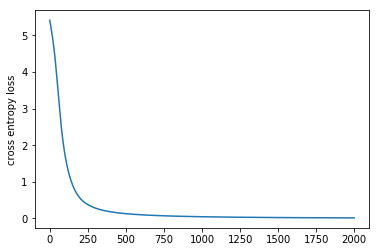

In [133]:
import matplotlib.pyplot as plt
plt.plot(log)
plt.ylabel('cross entropy loss')
plt.show()